             count        mean          std  min   25%    50%     75%      max
commit_role                                                                   
BFC          230.0   85.786957   200.333135  1.0  10.0   34.0   94.75   1883.0
BIC          304.0  642.796053  1888.648538  2.0  28.0  151.5  470.75  23612.0


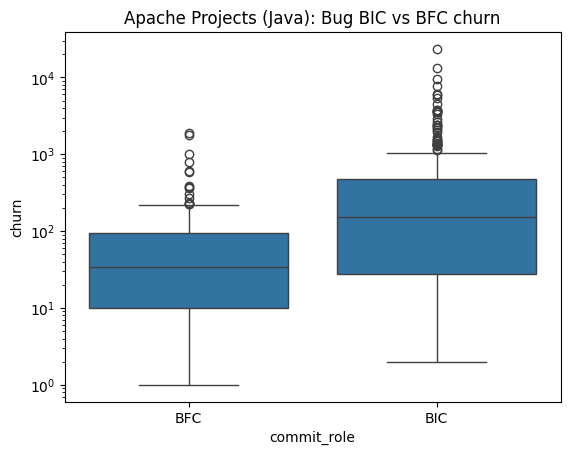

Mann-Whitney U: 50081.5 p-value: 1.0785692524616501e-17


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# 1. Load data
meta = pd.read_csv("../data/intermediate/commits_ds_apache.csv")
churn = pd.read_csv("../data/intermediate/churn.csv")
df = meta.merge(churn, on="commit_id")
df = df[df.churn > 0] # remove commits with 0 churn

# 2. Quick summary
print(df.groupby(["commit_role"]).churn.describe())

# 3. Visualization
sns.boxplot(data=df, x="commit_role", y="churn")
plt.yscale("log")
plt.title("Apache Projects (Java): Bug BIC vs BFC churn")
plt.show()

# 4. Statistical test
vic = df[df.commit_role=="BIC"].churn
vfc = df[df.commit_role=="BFC"].churn
stat, p = mannwhitneyu(vic, vfc, alternative="two-sided")
print("Mann-Whitney U:", stat, "p-value:", p)

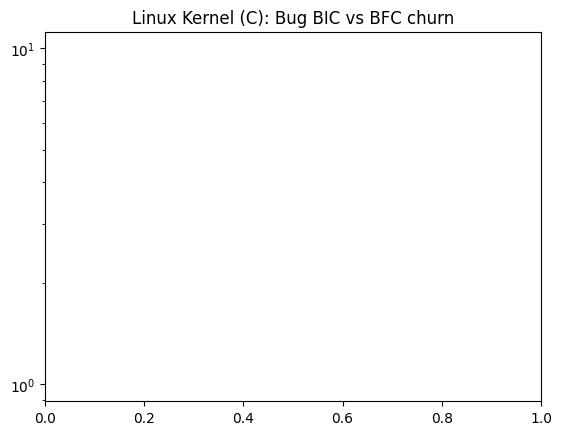

In [6]:
df = pd.read_csv("../data/intermediate/commits_dataset_linux.csv").merge(churn, on="commit_id")
df = df[df.churn > 0]

sns.boxplot(data=df, x="commit_role", y="churn")
plt.yscale("log")
plt.title("Linux Kernel (C): Bug BIC vs BFC churn")
plt.show()